In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip uninstall pandas-profiling
!pip install pandas-profiling[notebook,html]

Found existing installation: pandas-profiling 3.6.2
Uninstalling pandas-profiling-3.6.2:
  Would remove:
    /usr/local/bin/pandas_profiling
    /usr/local/lib/python3.8/dist-packages/pandas_profiling-3.6.2.dist-info/*
    /usr/local/lib/python3.8/dist-packages/pandas_profiling/*
Proceed (Y/n)? y
  Successfully uninstalled pandas-profiling-3.6.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pandas_profiling-3.6.2-py2.py3-none-any.whl (328 kB)


In [4]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

from pandas_profiling import ProfileReport

In [5]:
# flag setting
data_reducing = False ## memory reducing technique
feature_reducing = False ## feature extraction (curse of dimensionality)

In [6]:
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/data/nfl/'

In [7]:
tr_labels = pd.read_csv(f'{BASE_PATH}train_labels.csv')
tr_tracking = pd.read_csv(f'{BASE_PATH}train_player_tracking.csv')
tr_helmets = pd.read_csv(f'{BASE_PATH}train_baseline_helmets.csv')
tr_metadata = pd.read_csv(f'{BASE_PATH}train_video_metadata.csv')

In [8]:
te_tracking = pd.read_csv(f'{BASE_PATH}test_player_tracking.csv')
te_helmets = pd.read_csv(f'{BASE_PATH}test_baseline_helmets.csv')
te_metadata = pd.read_csv(f'{BASE_PATH}test_video_metadata.csv')

In [9]:
# profile = ProfileReport(tr_helmets.sample(n = 1000000, random_state = 42))
# profile.to_notebook_iframe()

In [10]:
# profile = ProfileReport(tr_tracking.sample(n = 1000000, random_state = 42))
# profile.to_notebook_iframe()

In [11]:
# profile = ProfileReport(te_helmets)
# profile.to_notebook_iframe()

In [12]:
# profile = ProfileReport(te_tracking)
# profile.to_notebook_iframe()

In [13]:
# profile = ProfileReport(tr_labels.sample(n = 1000000, random_state=42))
# profile.to_notebook_iframe()

# kaggle 참교 자료
https://www.kaggle.com/code/ahmedelfazouan/nfl-player-contact-detection-helmet-track-ftrs

In [14]:
import os
import torch

class Config:
    AUTHOR = "colum2131"

    NAME = "NFLC-" + "Exp001-simple-xgb-baseline"

    COMPETITION = "nfl-player-contact-detection"

    seed = 42
    num_fold = 5
    
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate':0.02,
        'tree_method':'hist' if not torch.cuda.is_available() else 'gpu_hist'
    }

In [15]:
!pip install cudf-cu11 dask-cudf-cu11 cuml-cu11 cugraph-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
!rm -rf /usr/local/lib/python3.8/dist-packages/cupy*
!pip install cupy-cuda11x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached cupy_cuda11x-11.4.0-cp38-cp38-manylinux1_x86_64.whl (93.7 MB)


In [16]:
import os
import gc
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Video, display

from scipy.optimize import minimize
import cv2
from glob import glob
from tqdm import tqdm

from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    roc_auc_score,
    matthews_corrcoef,
)

import xgboost as xgb

import torch

if torch.cuda.is_available():
    import cupy 
    import cudf
    from cuml import ForestInference

In [17]:
def setup(cfg):
    cfg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # set dirs
    cfg.INPUT = f'../input/{cfg.COMPETITION}'
    cfg.EXP = cfg.NAME
    cfg.OUTPUT_EXP = cfg.NAME
    cfg.SUBMISSION = './'
    cfg.DATASET = '../input/'

    cfg.EXP_MODEL = os.path.join(cfg.EXP, 'model')
    cfg.EXP_FIG = os.path.join(cfg.EXP, 'fig')
    cfg.EXP_PREDS = os.path.join(cfg.EXP, 'preds')

    # make dirs
    for d in [cfg.EXP_MODEL, cfg.EXP_FIG, cfg.EXP_PREDS]:
        os.makedirs(d, exist_ok=True)
        
    return cfg

In [18]:
def add_contact_id(df):
    # Create contact ids
    df["contact_id"] = (
        df["game_play"]
        + "_"
        + df["step"].astype("str")
        + "_"
        + df["nfl_player_id_1"].astype("str")
        + "_"
        + df["nfl_player_id_2"].astype("str")
    )
    return df

def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

# cross validation
def get_groupkfold(train, target_col, group_col, n_splits):
    kf = GroupKFold(n_splits=n_splits)
    generator = kf.split(train, train[target_col], train[group_col])
    fold_series = []
    for fold, (idx_train, idx_valid) in enumerate(generator):
        fold_series.append(pd.Series(fold, index=idx_valid))
    fold_series = pd.concat(fold_series).sort_index()
    return fold_series

# xgboost code
def fit_xgboost(cfg, X, y, params, add_suffix=''):
    """
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate':0.02,
        'tree_method':'gpu_hist'
    }
    """
    oof_pred = np.zeros(len(y), dtype=np.float32)
    for fold in sorted(cfg.folds.unique()):
        if fold == -1: continue
        idx_train = (cfg.folds!=fold)
        idx_valid = (cfg.folds==fold)
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        display(pd.Series(y_valid).value_counts())

        xgb_train = xgb.DMatrix(x_train, label=y_train)
        xgb_valid = xgb.DMatrix(x_valid, label=y_valid)
        evals = [(xgb_train,'train'),(xgb_valid,'eval')]

        model = xgb.train(
            params,
            xgb_train,
            num_boost_round=10_000,
            early_stopping_rounds=100,
            evals=evals,
            verbose_eval=100,
        )

        model_path = os.path.join(cfg.EXP_MODEL, f'xgb_fold{fold}{add_suffix}.model')
        model.save_model(model_path)
        if not torch.cuda.is_available():
            model = xgb.Booster().load_model(model_path)
        else:
            model = ForestInference.load(model_path, output_class=True, model_type='xgboost')
        pred_i = model.predict_proba(x_valid)[:, 1]
        oof_pred[x_valid.index] = pred_i
        score = round(roc_auc_score(y_valid, pred_i), 5)
        print(f'Performance of the prediction: {score}\n')
        del model; gc.collect()

    np.save(os.path.join(cfg.EXP_PREDS, f'oof_pred{add_suffix}'), oof_pred)
    score = round(roc_auc_score(y, oof_pred), 5)
    print(f'All Performance of the prediction: {score}')
    return oof_pred

def pred_xgboost(X, data_dir, add_suffix=''):
    models = glob(os.path.join(data_dir, f'xgb_fold*{add_suffix}.model'))
    if not torch.cuda.is_available():
         models = [xgb.Booster().load_model(model_path) for model in models]
    else:
        models = [ForestInference.load(model, output_class=True, model_type='xgboost') for model in models]
    preds = np.array([model.predict_proba(X)[:, 1] for model in models])
    preds = np.mean(preds, axis=0)
    return preds

In [19]:
cfg = setup(Config)

if not torch.cuda.is_available():
    tr_tracking = pd.read_csv(os.path.join(cfg.INPUT, f'{BASE_PATH}train_player_tracking.csv'), parse_dates=["datetime"])
    te_tracking = pd.read_csv(os.path.join(cfg.INPUT, f'{BASE_PATH}test_player_tracking.csv'), parse_dates=["datetime"])
    # tr_helmets = pd.read_csv(os.path.join(cfg.INPUT, 'train_baseline_helmets.csv'))
    # te_helmets = pd.read_csv(os.path.join(cfg.INPUT, 'test_baseline_helmets.csv'))
    # tr_video_metadata = pd.read_csv(os.path.join(cfg.INPUT, 'train_video_metadata.csv'))
    # te_video_metadata = pd.read_csv(os.path.join(cfg.INPUT, 'test_video_metadata.csv'))
    sub = pd.read_csv(os.path.join(cfg.INPUT, f'{BASE_PATH}sample_submission.csv'))

    train = pd.read_csv(os.path.join(cfg.INPUT, f'{BASE_PATH}train_labels.csv'), parse_dates=["datetime"])
    test = expand_contact_id(sub)
    
else:
    tr_tracking = cudf.read_csv(os.path.join(cfg.INPUT, f'{BASE_PATH}train_player_tracking.csv'), parse_dates=["datetime"])
    te_tracking = cudf.read_csv(os.path.join(cfg.INPUT, f'{BASE_PATH}test_player_tracking.csv'), parse_dates=["datetime"])
    # tr_helmets = cudf.read_csv(os.path.join(cfg.INPUT, 'train_baseline_helmets.csv'))
    # te_helmets = cudf.read_csv(os.path.join(cfg.INPUT, 'test_baseline_helmets.csv'))
    # tr_video_metadata = cudf.read_csv(os.path.join(cfg.INPUT, 'train_video_metadata.csv'))
    # te_video_metadata = cudf.read_csv(os.path.join(cfg.INPUT, 'test_video_metadata.csv'))
    sub = pd.read_csv(os.path.join(cfg.INPUT, f'{BASE_PATH}sample_submission.csv'))

    train = cudf.read_csv(os.path.join(cfg.INPUT, f'{BASE_PATH}train_labels.csv'), parse_dates=["datetime"])
    test = cudf.DataFrame(expand_contact_id(sub))

In [20]:
# ==============================
# feature engineering
# ==============================
def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        if torch.cuda.is_available():
            index = index.to_pandas()
            index = index.tolist()
            print(type(index))
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        if torch.cuda.is_available():
            tmp_distance_arr = tmp_distance_arr.to_pandas()
            tmp_distance_arr = tmp_distance_arr.tolist()
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols


use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]
train, feature_cols = create_features(train, tr_tracking, use_cols=use_cols)
test, feature_cols = create_features(test, te_tracking, use_cols=use_cols)
if torch.cuda.is_available():
    train = train.to_pandas()
    test = test.to_pandas()

display(train)

<class 'list'>
<class 'list'>


,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,speed_1,...,x_position_2,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flug
0,58168_003392_0_37084_37211,58168_003392,2020-09-11 03:01:48.100,0,37084,37211,0,41.90,20.08,0.54,...,39.59,17.07,0.53,0.05,134.84,84.73,1.43,1.42,3.794232,False
1,58168_003392_0_37084_38556,58168_003392,2020-09-11 03:01:48.100,0,37084,38556,0,41.90,20.08,0.54,...,41.93,30.61,0.67,0.05,232.50,227.00,1.82,1.61,10.530043,False
2,58168_003392_0_37084_38567,58168_003392,2020-09-11 03:01:48.100,0,37084,38567,0,41.90,20.08,0.54,...,40.37,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False
3,58168_003392_0_37084_38590,58168_003392,2020-09-11 03:01:48.100,0,37084,38590,0,41.90,20.08,0.54,...,40.33,25.28,0.52,0.06,141.08,100.37,0.59,0.58,5.431841,False
4,58168_003392_0_37084_39947,58168_003392,2020-09-11 03:01:48.100,0,37084,39947,0,41.90,20.08,0.54,...,40.11,26.73,0.99,0.09,163.38,90.69,1.68,1.64,6.886697,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4721613,58582_003121_91_52500_52619,58582_003121,2021-10-12 02:42:29.100,91,52500,52619,0,58.74,40.11,1.34,...,58.90,22.09,1.32,0.14,74.21,47.63,0.96,-0.44,18.020710,False
4721614,58582_003121_91_52500_G,58582_003121,2021-10-12 02:42:29.100,91,52500,G,0,58.74,40.11,1.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4721615,58582_003121_91_52609_52619,58582_003121,2021-10-12 02:42:29.100,91,52609,52619,0,60.32,25.93,1.38,...,58.90,22.09,1.32,0.14,74.21,47.63,0.96,-0.44,4.094142,False
4721616,58582_003121_91_52609_G,58582_003121,2021-10-12 02:42:29.100,91,52609,G,0,60.32,25.93,1.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [21]:
corr = train.corr()

corr.contact.sort_values(ascending=False)

contact           1.000000
G_flug            0.072524
x_position_1      0.004013
direction_2       0.002372
orientation_1     0.001996
acceleration_2    0.001943
direction_1       0.001686
acceleration_1    0.000961
x_position_2     -0.000112
orientation_2    -0.000429
y_position_2     -0.004413
y_position_1     -0.005155
step             -0.011586
sa_2             -0.022218
distance_2       -0.024288
speed_2          -0.025268
sa_1             -0.028995
distance_1       -0.039709
speed_1          -0.040980
distance         -0.131263
Name: contact, dtype: float64

In [22]:
import seaborn as sns

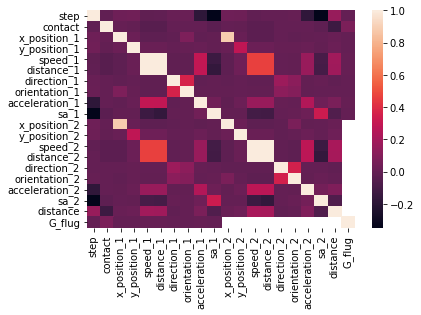

In [23]:
corr_contact = train.corr()

sns.heatmap(corr_contact)

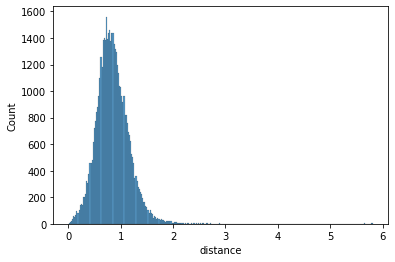

In [24]:
train_contact = train.loc[train.contact==1]
sns.histplot(data=train_contact, x='distance')

In [25]:
DISTANCE_THRESH = 1.5

train_y = train['contact'].values
oof_pred = np.zeros(len(train))
cond_dis_train = (train['distance']<=DISTANCE_THRESH) | (train['distance'].isna())
cond_dis_test = (test['distance']<=DISTANCE_THRESH) | (test['distance'].isna())

train = train[cond_dis_train]
train.reset_index(inplace = True, drop = True)

print('number of train data : ',len(train))

_ = gc.collect()

number of train data :  562000


In [26]:
CLUSTERS = [10, 50, 100, 300, 500]

def add_step_pct(df, cluster):
    df['step_pct'] = cluster * (df['step']-min(df['step']))/(max(df['step'])-min(df['step']))
    df['step_pct'] = df['step_pct'].apply(np.ceil).astype(np.int32)
    return df

for cluster in CLUSTERS:
    train = train.groupby('game_play').apply(lambda x:add_step_pct(x,cluster))
    test = test.groupby('game_play').apply(lambda x:add_step_pct(x,cluster))

    for helmet_view in ['Sideline', 'Endzone']:
        helmet_train = pd.read_csv(f'{BASE_PATH}/train_baseline_helmets.csv')
        helmet_train.loc[helmet_train['view']=='Endzone2','view'] = 'Endzone'
        helmet_test = pd.read_csv(f'{BASE_PATH}/test_baseline_helmets.csv')
        helmet_test.loc[helmet_test['view']=='Endzone2','view'] = 'Endzone'

        helmet_train.rename(columns = {'frame': 'step'}, inplace = True)
        helmet_train = helmet_train.groupby('game_play').apply(lambda x:add_step_pct(x,cluster))
        helmet_test.rename(columns = {'frame': 'step'}, inplace = True)
        helmet_test = helmet_test.groupby('game_play').apply(lambda x:add_step_pct(x,cluster))
        helmet_train = helmet_train[helmet_train['view']==helmet_view]
        helmet_test = helmet_test[helmet_test['view']==helmet_view]

        helmet_train['helmet_id'] = helmet_train['game_play'] + '_' + helmet_train['nfl_player_id'].astype(str) + '_' + helmet_train['step_pct'].astype(str)
        helmet_test['helmet_id'] = helmet_test['game_play'] + '_' + helmet_test['nfl_player_id'].astype(str) + '_' + helmet_test['step_pct'].astype(str)

        helmet_train = helmet_train[['helmet_id', 'left', 'width', 'top', 'height']].groupby('helmet_id').mean().reset_index()
        helmet_test = helmet_test[['helmet_id', 'left', 'width', 'top', 'height']].groupby('helmet_id').mean().reset_index()
        for player_ind in [1, 2]:
            train['helmet_id'] = train['game_play'] + '_' + train['nfl_player_id_'+str(player_ind)].astype(str) + \
                                    '_' + train['step_pct'].astype(str)
            test['helmet_id'] = test['game_play'] + '_' + test['nfl_player_id_'+str(player_ind)].astype(str) + \
                                    '_' + test['step_pct'].astype(str)

            train = train.merge(helmet_train, how = 'left')
            test = test.merge(helmet_test, how = 'left')

            train.rename(columns = {i:i+'_'+helmet_view+'_'+str(cluster)+'_'+str(player_ind) for i in ['left', 'width', 'top', 'height']}, inplace = True)
            test.rename(columns = {i:i+'_'+helmet_view+'_'+str(cluster)+'_'+str(player_ind) for i in ['left', 'width', 'top', 'height']}, inplace = True)

            del train['helmet_id'], test['helmet_id']
            gc.collect()

            feature_cols += [i+'_'+helmet_view+'_'+str(cluster)+'_'+str(player_ind) for i in ['left', 'width', 'top', 'height']]
        del helmet_train, helmet_test
        gc.collect()

In [27]:
for cluster in CLUSTERS:
    for helmet_view in ['Sideline', 'Endzone']:
        train.loc[train['G_flug']==True,'left_'+helmet_view+'_'+str(cluster)+'_2'] = train.loc[train['G_flug']==True,'left_'+helmet_view+'_'+str(cluster)+'_1']
        train.loc[train['G_flug']==True,'top_'+helmet_view+'_'+str(cluster)+'_2'] = train.loc[train['G_flug']==True,'top_'+helmet_view+'_'+str(cluster)+'_1']
        train.loc[train['G_flug']==True,'width_'+helmet_view+'_'+str(cluster)+'_2'] = 0
        train.loc[train['G_flug']==True,'height_'+helmet_view+'_'+str(cluster)+'_2'] = 0
        
        test.loc[test['G_flug']==True,'left_'+helmet_view+'_'+str(cluster)+'_2'] = test.loc[test['G_flug']==True,'left_'+helmet_view+'_'+str(cluster)+'_1']
        test.loc[test['G_flug']==True,'top_'+helmet_view+'_'+str(cluster)+'_2'] = test.loc[test['G_flug']==True,'top_'+helmet_view+'_'+str(cluster)+'_1']
        test.loc[test['G_flug']==True,'width_'+helmet_view+'_'+str(cluster)+'_2'] = 0
        test.loc[test['G_flug']==True,'height_'+helmet_view+'_'+str(cluster)+'_2'] = 0

In [28]:
cols = [i[:-2] for i in train.columns if i[-2:]=='_1' and i!='nfl_player_id_1']
train[[i+'_diff' for i in cols]] = np.abs(train[[i+'_1' for i in cols]].values - train[[i+'_2' for i in cols]].values)
test[[i+'_diff' for i in cols]] = np.abs(test[[i+'_1' for i in cols]].values - test[[i+'_2' for i in cols]].values)
feature_cols += [i+'_diff' for i in cols]

cols = ['x_position', 'y_position', 'speed', 'distance', 'direction', 'orientation', 'acceleration', 'sa']
train[[i+'_prod' for i in cols]] = train[[i+'_1' for i in cols]].values * train[[i+'_2' for i in cols]].values
test[[i+'_prod' for i in cols]] = test[[i+'_1' for i in cols]].values * test[[i+'_2' for i in cols]].values
feature_cols += [i+'_prod' for i in cols]

print('number of features : ',len(feature_cols))
print('number of train data : ',len(train))

number of features :  154
number of train data :  562000


In [29]:
type(train), type(test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [30]:
train[feature_cols]

,x_position_1,y_position_1,speed_1,distance_1,direction_1,orientation_1,acceleration_1,sa_1,x_position_2,y_position_2,...,top_Endzone_500_diff,height_Endzone_500_diff,x_position_prod,y_position_prod,speed_prod,distance_prod,direction_prod,orientation_prod,acceleration_prod,sa_prod
0,41.90,20.08,0.54,0.06,252.69,262.31,0.92,0.90,NaN,NaN,...,0.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,39.59,17.07,0.53,0.05,134.84,84.73,1.43,1.42,40.34,18.08,...,29.0,1.0,1597.0606,308.6256,0.583,0.005,20081.7212,7828.2047,2.9029,2.8826
2,39.59,17.07,0.53,0.05,134.84,84.73,1.43,1.42,NaN,NaN,...,0.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,41.93,30.61,0.67,0.05,232.50,227.00,1.82,1.61,NaN,NaN,...,0.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40.37,19.88,0.66,0.07,136.70,88.92,0.90,0.89,NaN,NaN,...,0.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561995,33.18,25.26,2.55,0.26,95.39,152.22,0.43,-0.40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561996,65.04,38.68,1.31,0.14,168.40,143.47,0.74,-0.69,NaN,NaN,...,0.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561997,58.74,40.11,1.34,0.13,204.96,136.56,1.23,-1.20,NaN,NaN,...,0.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
561998,60.32,25.93,1.38,0.15,261.77,269.45,0.35,-0.30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# ==============================
# training & inference
# ==============================

cfg.folds = get_groupkfold(train, 'contact', 'game_play', cfg.num_fold)
cfg.folds.to_csv(os.path.join(cfg.EXP_PREDS, 'folds.csv'), index=False)

oof_pred[np.where(cond_dis_train)] = fit_xgboost(cfg, train[feature_cols], train['contact'], 
                                              cfg.xgb_params, add_suffix="_xgb_1st")
np.save('oof_pred.npy',oof_pred)
sub_pred = pred_xgboost(test.loc[cond_dis_test, feature_cols], cfg.EXP_MODEL, add_suffix="_xgb_1st")

0    99136
1    13207
Name: contact, dtype: int64

[0]	train-auc:0.904581	eval-auc:0.888376
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[200]	train-auc:0.954132	eval-auc:0.930537
[400]	train-auc:0.966023	eval-auc:0.9344
[600]	train-auc:0.972042	eval-auc:0.93586
[800]	train-auc:0.976441	eval-auc:0.936387
Stopping. Best iteration:
[853]	train-auc:0.977416	eval-auc:0.936478

Performance of the prediction: 0.93636



0    99284
1    13094
Name: contact, dtype: int64

[0]	train-auc:0.908431	eval-auc:0.888007
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[200]	train-auc:0.953956	eval-auc:0.928714
[400]	train-auc:0.965814	eval-auc:0.934038
[600]	train-auc:0.971565	eval-auc:0.935277
[800]	train-auc:0.975981	eval-auc:0.935745
[1000]	train-auc:0.979289	eval-auc:0.936092
Stopping. Best iteration:
[1015]	train-auc:0.979532	eval-auc:0.936118

Performance of the prediction: 0.93608



0    101109
1     11353
Name: contact, dtype: int64

[0]	train-auc:0.902693	eval-auc:0.903707
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[200]	train-auc:0.951467	eval-auc:0.943536
[400]	train-auc:0.963625	eval-auc:0.94898
[600]	train-auc:0.969612	eval-auc:0.950519
[800]	train-auc:0.974296	eval-auc:0.951349
[1000]	train-auc:0.977894	eval-auc:0.951945
[1200]	train-auc:0.98093	eval-auc:0.952008
Stopping. Best iteration:
[1145]	train-auc:0.980053	eval-auc:0.95205

Performance of the prediction: 0.95204



0    99302
1    13116
Name: contact, dtype: int64

[0]	train-auc:0.906721	eval-auc:0.901012
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[200]	train-auc:0.95229	eval-auc:0.936838
[400]	train-auc:0.963873	eval-auc:0.941126
[600]	train-auc:0.970275	eval-auc:0.942696
[800]	train-auc:0.974872	eval-auc:0.943383
[1000]	train-auc:0.97845	eval-auc:0.943789
[1200]	train-auc:0.981261	eval-auc:0.94415
Stopping. Best iteration:
[1244]	train-auc:0.981872	eval-auc:0.944198

Performance of the prediction: 0.9441



0    99927
1    12472
Name: contact, dtype: int64

[0]	train-auc:0.902348	eval-auc:0.903519
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 100 rounds.
[200]	train-auc:0.950854	eval-auc:0.944922
[400]	train-auc:0.963648	eval-auc:0.949411
[600]	train-auc:0.970316	eval-auc:0.950082
[800]	train-auc:0.974685	eval-auc:0.950256
Stopping. Best iteration:
[705]	train-auc:0.972831	eval-auc:0.950292

Performance of the prediction: 0.95028

All Performance of the prediction: 0.94326


In [32]:
# ==============================
# optimize
# ==============================
def func(x_list):
    score = matthews_corrcoef(train_y, oof_pred>x_list[0])
    return -score

x0 = [0.5]
result = minimize(func, x0,  method="nelder-mead")
cfg.threshold = result.x[0]
print("score:", round(matthews_corrcoef(train_y, oof_pred>cfg.threshold), 5))
print("threshold", round(cfg.threshold, 5))
del train
gc.collect()

test = add_contact_id(test)
test['contact'] = 0
test.loc[cond_dis_test, 'contact'] = (sub_pred > cfg.threshold).astype(int)
test[['contact_id', 'contact']].to_csv('submission.csv', index=False)
display(test[['contact_id', 'contact']].head())

score: 0.66059
threshold 0.30518


,contact_id,contact
0,58168_003392_0_37084_37211,0
1,58168_003392_0_37084_38556,0
2,58168_003392_0_37084_38567,0
3,58168_003392_0_37084_38590,0
4,58168_003392_0_37084_39947,0


In [33]:
ㅇ리ㅏㄴ멍 ㅁㄴㅇㄻㄴㅇㄹ ㄴㅇㅁㄻㄴㄹㄹ

SyntaxError: ignored

In [ ]:
!pip install optuna
!pip install xgboost==1.6.0
!pip install lightgbm==3.3.2
!pip install overrides

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from overrides import overrides
import copy
import os
import warnings
warnings.filterwarnings(action='ignore')

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost.sklearn import XGBClassifier

# classification metrics
from sklearn.metrics import confusion_matrix, plot_roc_curve, f1_score, accuracy_score, auc

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm.sklearn import LGBMRegressor
from xgboost.sklearn import XGBRegressor

# regression metrics
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold, StratifiedKFold
from functools import partial

# optimize : hyper-parameter tuning
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

# modules for calss imbalance problem
from sklearn.decomposition import PCA # 차원축소
from sklearn.metrics import classification_report # 성과지표
from imblearn.under_sampling import * # 임벨런스
from imblearn.over_sampling import * # 임벨런스
from imblearn.combine import * # 임벨런스
from imblearn.pipeline import Pipeline # 파이프라인구축

In [ ]:
class oil:
    def __init__(self, train, test):
        base_path = '/content/drive/MyDrive/dacon/oil/'
        self.load_path = base_path + 'data/'
        self.save_path = base_path + 'submission/'
        self.train = pd.read_csv(self.load_path + 'train.csv')
        self.test = pd.read_csv(self.load_path + 'test.csv')
        self.submission = pd.read_csv(self.load_path + 'sample_submission.csv')
    
    def make_X_y(self) -> None:
        self.X = self.train.drop(columns=['ID', 'Y_LABEL'])
        self.y = self.train.Y_LABEL
        self.test = self.test.drop(columns=['ID'])

    def reset_data(self, mode: str=None):
        if mode is None:
            self.train = pd.read_csv(self.load_path + 'train.csv')
            self.test = pd.read_csv(self.load_path + 'test.csv')
        elif mode == 'train':
            self.train = pd.read_csv(self.load_path + 'train.csv')
        elif mode == 'test':
            self.test = pd.read_csv(self.load_path + 'test.csv')

    def split(self, X, y):
        return train_test_split(X, y, test_size=0.25, random_state=42)

    def multilinearity(self, threshold: float|list=0.7):
        pass
    
    def feature_importance_remove(self, threshold: float|list=0.01):
        pass
    
    def drop_columns(self, columns):
        try:
            if type(columns) == list:
                for col in columns:
                    if col in self.X_test.columns:
                        self.X = self.X.drop(columns=[col])
                        self.X_test = self.X_test.drop(columns=[col])
                    else:
                        self.X = self.X.drop(columns=[col])

            elif type(columns) == str:
                if col in self.X_test.columns:
                    self.X = self.X.drop(columns=[columns])
                    self.X_test = self.X_test.drop(columns=[columns])
                else:
                    self.X = self.X.drop(columns=[columns])
        except:
            print("Not exist those columns. Don't do that")
                
    def modeling(self):
        """
        feature_importance 제거를 위한 기본 모델
        """
        pass

    def grouping(self, categorical_feature: str='COMPONENT_ARBITRARY') -> dict:
        group = {}
        for criteria in self.train[categorical_feature].unique():
            print(f"dividing my df on {criteria}")
            temp_df = self.train.loc[self.train[categorical_feature] == criteria, :].drop(columns=categorical_feature)
            group.update({criteria: temp_df})
        
        return group

    def sampling(self, X, y, sampling_mode: str='under', sampler_type: str='RandomUnderSampler'):
        """
        Parameters
        sampling_mode :
        - 'under' : undersampling(default)
          - 
        - 'over' : oversampling
        - 'hybrid' : under + over
        """
        self.samplers = {
            "under" : {
                'RandomUnderSampler': RandomUnderSampler(),
                'TomekLinks': TomekLinks(),
                'CondensedNearestNeighbour': CondensedNearestNeighbour(), 
                'OneSidedSelection': OneSidedSelection(),
                'EditedNearestNeighbours': EditedNearestNeighbours(),
                'NeighbourhoodCleaningRule': NeighbourhoodCleaningRule()
            },

            "over" : {
                'RandomOverSampler': RandomOverSampler(),
                'ADASYN': ADASYN(),
                'NeighbourhoodCleaningRule': NeighbourhoodCleaningRule()
            },

            "hybrid" : {
                'SMOTEENN': SMOTEENN(),
                'SMOTETomek': SMOTETomek()
            }
        }

        X2, y2 = sampling_method_info[sampling_mode][sampler_type].fit_resample(X, y)
        return X2, y2
    
    def report(X: pd.DataFrame, y: pd.DataFrame, sampling_method: callable = None, dimensionality: callable = None, model: callable = None) -> str: 
        """
        사용법:
        pca = PCA()
        rfc = RandomForestClassifier()
        rmu = RandomUnderSampler()
        pipine(rmu, pca, rfc)
        """
        pipeline = Pipeline([('sampling_method', sampling_method),
                             ('dimensionality', dimensionality),
                             ('model', model)]) # sampling method, dimensionality, model
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        pipeline.fit(X_train, y_train)
        y_hat = pipeline.predict(X_test)
        #print(type(classification_report(y_test, y_hat)))
        return classification_report(y_test, y_hat)

    def data_split(self):
        pass

    def make_full_testset(self, encoder):
        train_cols = list(X.columns)
        test_cols = list(test.columns)
        resid_cols = list(set(train_cols) - set(test_cols))

        self.X2 = X.drop(columns=resid_cols)
        y_list = [X[col] for col in resid_cols]
        final_models = []

        for y, col in zip(y_list, resid_cols):
            errors = []
            # set the weak(?) leaners
            models = [RandomForestRegressor(random_state=42),
                      DecisionTreeRegressor(random_state=42),
                      LGBMRegressor(random_state=42),
                      XGBRegressor(random_state=42)]

            X2_train, X2_val, y_train, y_val = train_test_split(self.X2, y, test_size=0.25, random_state=42)

            for model in models:
                name = str(model).split('(')[0]
                model.fit(X2_train, y_train)
                predict = model.predict(X3_val)
                mae = mean_absolute_error(y_val, predict)
                errors.append(mae)
            
            min_error_index = errors.index(min(errors))
            final_models.append(models[min_error_index])

        if 'COMPONENT_ARBITRARY' in test.columns:
            test['COMPONENT_ARBITRARY'] = encoder.transform(test['COMPONENT_ARBITRARY'])
            test_num_cols = list(test.columns.values)
            test_num_cols.remove('COMPONENT_ARBITRARY')

        ss = StandardScaler()
        ss.fit(X[test_num_cols])
        test[test_num_cols] = ss.transform(test[test_num_cols])

        for model, col in zip(final_models, resid_cols):
            test[col] = model.predict(test[test_cols])

        return test

    def make_submission(self, test: pd.DataFrame):
        # Check submission file name and define file name
        if 'submission_bike.csv' in os.listdir(self.save_path):
            count = 0
            for name in os.listdir(self.save_path):
                if 'submission_bike' in name:
                    count += 1
            filename = f"submission_bike{count + 1}.csv"
        else:
            filename = 'submission_bike.csv'

        # Export submission file
        self.submission.Y_LABEL = self.main_model.predict(test)
        self.submission.to_csv(self.save_path + filename, index=False)

# ---------------------------------------------------------------------------- #
#          Make Sampling Pipeline for solving class imbalance problem          #
# ---------------------------------------------------------------------------- #

    def random_forest_call(self, split_data) :
        """
        main use will be supplement function for classifier_with_group
        """
        classifier_without_dic = RandomForestClassifier()  # Random Forest 분류기 불러오기
        acc_dic = {}
        for criteria, (X_train, X_test, y_train, y_test) in split_data.items() : 
            classifier_without_dic.fit(X_train, y_train) # Random Forest 학습을 위해 parameter 채우기
            pred = classifier_without_dic.predict(X_test) # Random Forest 테스트를 위해 parameter 채우기
            acc = f1_score(y_test, pred)  # f1_score 계산
            acc_dic[f"{criteria}"] = acc
            #print(classification_report(tuple_dic[2], pred))
            print("f1_score : %.3f" % acc)

        return classifier_without_dic, acc_dic

    def classifier_with_group(self, classifier, dic) : 
        """
        return list that contains all classifier for each group 
        """
        classifier_list = []
        for key in dic : 
            df = dic[key]
            classifier_with_group = self.random_forest_call(X_train = df[0], y_train = df[2], X_test = df[1], y_test = df[3])
            classifier_list.append(classifier_with_group)
        return classifier_list

# ---------------------------------------------------------------------------- #
#                 Make Model Pipeline for the multiple tests                   #
# ---------------------------------------------------------------------------- #

class Ensemble:
    """
    Ensemble & Optimize 3 models(RandomForest, XGBoost, LightGBM)
    - (model_type : Classifier / Regressor) Ensemble with (ensemble : voting / stacking)
    """
    def __init__(self, metric: str, learner: str='auto', ensemble: str='voting'):
        """
        ensemble : 'voting', 'stacking'
        """
        self.final_ensemble = None        # Final Ensemble model
        self.models = {
            'RF': None,
            'XGB': None,
            'LGBM': None
        }
        
        # self.metric_dict[self.type_][self.metric_]
        self.metric_dict = {
            'classification': {
                'accuracy_score': accuracy_score,
                'f1_score': f1_score,
                'auc': auc
            },
            'regression': {
                'mae': mean_absolute_error,
                'mse': mean_squared_error,
                'msle': mean_squared_log_error,
                'mape': mean_absolute_percentage_error,
                'r2_score': r2_score
            }
        }
        # self.metric_direction_dict[self.type_][self.metric_]
        self.metric_direction_dict = {
            'classification': {
                'accuracy_score': 'maximize',
                'f1_score': 'maximize',
                'auc': 'maximize'
            },

            'regression': {
                'mae': 'minimize',
                'mse': 'minimize',
                'rmse': 'minimize',
                'msle': 'minimize',
                'rmsle': 'minimize',
                'mape': 'minimize',
                'r2_score': 'maximize'
            }
        }

        # Initializing hyper-parameter for each model
        # self.param[self.learner_]
        self.param = {
            'RF' : {'learning_rate': 0.001,
                    'n_jobs': -1,
                    'random_state': 42},

            'XGB' : {'learning_rate': 0.001,
                     'nthread' : -1,
                     'n_jobs': -1,
                     'tree_method': 'gpu_hist',
                     'predictor': 'gpu_predictor',
                     'random_state': 42},
                      
            'LGBM' : {'learning_rate': 0.001,
                      'n_jobs': -1,
                      'random_state': 42}
        }

        # self.learners[self.type_][self.learner_]
        self.learners = {
            'classification' : {
                'RF': RandomForestClassifier,
                'XGB': XGBClassifier,
                'LGBM': LGBMClassifier
            },
            
            'regression' : {
                'RF': RandomForestRegressor,
                'XGB': XGBRegressor,
                'LGBM': LGBMRegressor
            }
        }

        # self.voters[self.type_][self.emsemble_]
        self.voters = {
            'classification' : {
                'voting' : VotingClassifier,
                'stacking' : StackingClassifier
            },
            
            'regression' : {
                'voting' : VotingRegressor,
                'stacking' : StackingRegressor
            }
        }

        # 'classification' , 'regression'
        self.type_ = ''
        self.learner_ = ['RF', 'XGB', 'LGBM'] if learner == 'auto' else [learner]
        self.ensemble_ = ensemble if ensemble in ['voting', 'stacking'] else 'voting'
        self.metric_ = metric

    def make_weights(self, N: int) -> list:
        # x+y+z = 5인 음이 아닌 정수 (x, y, z) 순서쌍 만들기
        weights = []
        for i in range(N+1):
            for j in range(N+1-i):
                k = N-i-j
                temp = [i/N, j/N, k/N]
                weights.append(temp)
        return weights
        
    def fit(self, X_train: pd.DataFrame, y_train: pd.Series | np.ndarray, N: int=5) -> None:
        for learner in self.learner_: 
            # RF, XGB, LGBM 순서대로 hyper-parameter tuning
            param = self.optimizer(X_train, y_train, learner, 250)
            # Hyper-parameter fix + tuning
            self.param[learner].update(param)
            # Set up final models
            self.models[learner] = self.learners[self.type_][learner](**self.param[learner])
            self.models[learner].fit(X_train, y_train)
        
        estimators = [(learner, self.models[learner]) for learner in self.learner_]
        weights = self.make_weights(N)
        
        # 'weights': weights,
        ensemble_param = {
            'estimators': estimators,
            'n_jobs': -1
        }
        if self.ensemble_ == 'voting':
            ensemble_param.update({'voting': 'soft'})
        
        self.final_ensemble = self.voters[self.type_][self.ensemle_](**ensemble_param)

        grid_params = {'weights': weights}
        grid_Search = GridSearchCV(param_grid = grid_params, estimator=self.final_ensemble, scoring=self.metric_dict[self.type_][self.metric_])
        grid_Search.fit(X_train, y_train)
        self.final_ensemble = grid_Search.best_estimator_

    def predict(self, X_test: pd.DataFrame) -> np.ndarray:
        return self.final_ensemble.predict(X_test)

    def score(self, y_test: pd.Series | np.ndarray, y_pred: pd.Series | np.ndarray) -> float:
        return self.metric_dict[self.type_][self.metric_](y_test, y_pred)

    def K_fold(self, model, X, y, cv) -> list:
        scores = []
        folds = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        
        if cv == 1:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/cv, random_state=42)
            model.fit(X_train, y_train, verbose=False)
            score = self.score(y_val, model.predict(X_val))
            scores.append(score)
        else:
            for train_idx, val_idx in folds.split(X, y):
                X_train = X.iloc[train_idx, :]
                y_train = y.iloc[train_idx]
                
                X_val = X.iloc[val_idx, :]
                y_val = y.iloc[val_idx]
                
                model.fit(X_train, y_train, verbose=False)
                score = self.score(y_val, model.predict(X_val))
                scores.append(score)

        return scores

    def objective(self, trial: Trial, X, y, learner: str, cv: int=5) -> float:
        temp = copy.deepcopy(self.param[learner])
        
        if learner == 'RF': # RandomForest
            param = {
                "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
                'max_depth':trial.suggest_int('max_depth', 8, 16),
                'learning_rate': 0.05
            }

        elif learner == 'XGB': # XGB
            param = {
                "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
                'max_depth':trial.suggest_int('max_depth', 8, 16),
                'min_child_weight':trial.suggest_int('min_child_weight', 1, 300),
                'gamma':trial.suggest_int('gamma', 1, 3),
                'learning_rate': 0.05,
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.5, 1, 0.1),
                'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
                'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
                'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0] )
            }

        elif learner == 'LGBM': # LGBM
            param = {
                'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
                'max_depth': trial.suggest_int('max_depth', 1, 10, step=1, log=False), 
                'learning_rate': 0.05,
                'n_estimators': trial.suggest_int('n_estimators', 8, 1024, step=1, log=True), 
                'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
                'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=1, log=False), 
                'subsample': trial.suggest_uniform('subsample', 0.7, 1.0), 
                'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
                'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
                'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0)
            }

        else:
            raise Exception("Not exist those model. Please choose the number in [0, 1, 2]\nTry again.")
        
        # Set up param
        temp.update(param)
        param = temp

        # Set up the model by flag
        model = self.learners[self.type_][learner](**param)
        
        # K-fold cross validation
        scores = self.K_fold(model, X, y, cv)

        return np.mean(scores)
    
    def optimizer(self, X: pd.DataFrame, y: pd.Series | np.ndarray,
                  learner: str, n_trials: int=100) -> dict:
        
        study = optuna.create_study(direction=self.metric_direction_dict[self.type_][self.metric_], 
                                    sampler=TPESampler())
        study.optimize(lambda trial : self.objective(trial, X, y, learner), n_trials=n_trials)
        print('Best trial: score {},\nparams: {}'.format(study.best_trial.value, study.best_trial.params))
        return study.best_trial.params

class BinaryCalssifier(Ensemble):
    # Child Class
    """
    metric : F1 score
    """
    def __init__(self, metric: str, learner: str='auto', ensemble: str='voting'):
        super().__init__(metric, learner, ensemble)
        # 'classification' Type
        self.type_ = 'classification'
        self.param['LGBM'] = {'objective': 'binary',
                              'learning_rate': 0.05,
                              'random_state': 42}   # LightGBM

class Regressor(Ensemble):
    # Child Class
    """
    metric : R-squared score
    """
    def __init__(self, metric: str, learner: str='auto', ensemble: str='voting'):
        super().__init__(metric, learner, ensemble)
        # 'regression' Type
        self.type_ = 'regression'